In [2]:
#Stochastic with Delay and Isolation, Verion 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def estBetaParams(mu, var):
    alpha=((1 - mu) / var - 1 / mu) * mu**2
    beta=alpha * (1 / mu - 1)
    return alpha,beta

def estGammaParams(mu,var):
    shape=(mu**2)/var
    scale=var/mu
    return shape, scale


#Non-Stochastic Parameters Parameters

N = 250000               # Total population
p_3months = 0.5          # Proportion tested every 3 months
p_12months = 1-p_3months         # Proportion tested every 12 months
tau = 7                 # This is our key parameter; the average return time for tests.

# The (weighted) average testing proportion for our population (proportion per day)
average_testing_proportion = (p_3months/91 + p_12months/365)
tests_per_day=N*average_testing_proportion
# I think that the generic person will get tested with this probability each day, and so the waiting
# time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
# No.... maybe it should be with rate tests_per_day??

# Initial conditions
E0 = 0.5 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
A_u_sc0 = 0              # Initial asymptomatic individuals who are untested, and will clear on their own (self-clear).
A_u_p0 = 0               # Initial asympt. who are untested and will not clear on their own (persistent)
A_t0 = 0                 # Initial asympt. who are tested (positive). These individuals will isolate. 


#note: we will assume perfect isolation
#note: since we are assuming routine testing, we assume that testees do not change their habits unless
#      they receive a positive test. 

#Initial Stochastic parameters:

#Stochastic params
np.random.seed(123) #get rid of this for simulations

#beta is the transmission rate, infection probability is beta with mean 0.8
# times (3 partners per month) distributed like a gamma dist. 
beta = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1])*np.random.gamma(estGammaParams(3,1)[0],estGammaParams(3,1)[1])/30  

# Rate of progression from exposed to infectious. We assume exposed individuals are not transmitting. 
# Duration here is assumed to be gamma. Small constant added for numerical stability
epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  

# Recovery rate for individuals undergoing treatment. 
# Assumed to be gamma with mean 7 days+- 1 day. Small constant added for numerical stability
gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 

# proportion of infected, asymptomatic individuals who will self-clear. Assumed to be 
# beta with expected value 0.6
theta=np.random.beta(estBetaParams(0.6,0.01)[0],estBetaParams(0.8,0.01)[1])

# Natural recovery rate for untreated individuals who will self-clear (estimated to be about 2 weeks) !!Find Ref!
# Assumed to be gamma. Small constant added for numerical stability. 
gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 

# Proportion developing asymptomatic infection
# Assumed to be beta with expected value 0.8 and variance 0.01
lambda_ = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1]) 

# Amount of time someone should wait until their next test:
# Assumed to be exponential with rate average_testing_proportion.
# small constant added for numerical stability
omega_t = np.random.exponential(tests_per_day)+0.00000000000001

# Amount of time someone can expect to wait until their test results.
# Assumed to be gamma with expected value tau and variance 1. Small constant added for numerical stability.
omega_r = np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001
# THIS is the key value. 

    

In [3]:
#Define the Model 

def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_t, omega_r, average_testing_proportion , tau, N):
    # Since we cannot directly use the delayed A value in the ODEs, we need to find a workaround
    # Using the history of A to find the delayed value
    # We interpolate linearly between points. 
    A_u_sc_delayed = np.interp(t - tau, t_points, A_u_sc_history)
    A_u_p_delayed = np.interp(t - tau, t_points, A_u_p_history)
    
    X, E, S, A_u_sc, A_u_p, A_t = Y
    
    
    # Here, we assume that the only groups driving the spread of infection are the asymptomatic untested
    dXdt = -beta*X*(A_u_sc+A_u_p)/N + gamma_t*S + gamma_u*A_u_sc + gamma_t*A_t
    
    
    dEdt = beta*X*(A_u_sc+A_u_p)/N - epsilon*E
    
    
    dSdt = (1-lambda_)*epsilon*E - gamma_t*S
    
    
    #dA_u_scdt = theta*lambda_*epsilon*E - gamma_u*A_u_sc - (1/(omega_t+omega_r))*A_u_sc_delayed 
    
    
    #dA_u_pdt = (1-theta)*lambda_*epsilon*E - (1/(omega_t+omega_r))*A_u_p_delayed #This is all the trouble. People accumulate here!
    
    
    #dA_tdt = (1/(omega_t+omega_r))*A_u_p_delayed + (1/(omega_t+omega_r))*A_u_sc_delayed - gamma_t*A_t
    
    
    dA_u_scdt = theta*lambda_*epsilon*E - gamma_u*A_u_sc - (1/omega_r)*A_u_sc
    
    
    dA_u_pdt = (1-theta)*lambda_*epsilon*E - (1/omega_r)*A_u_p
    
    
    dA_tdt = (1/(omega_r))*A_u_p + (1/(omega_r))*A_u_sc - gamma_t*A_t
    
    return [dXdt, dEdt, dSdt, dA_u_scdt, dA_u_pdt, dA_tdt]

In [4]:
#Simulation 

# Time array: Simulate over 10 years

print("hello world")

t_points = np.linspace(0, 100 * 365, 100 * 365)


# We need to keep a history of the A compartments to look up delayed values
A_u_p_history = np.zeros(t_points.shape)
A_u_sc_history = np.zeros(t_points.shape)
A_u_p_history[0] = A_u_sc0 
A_u_sc_history[0] = A_u_p0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 6))
solution[0] = [X0, E0, S0, A_u_sc0, A_u_p0, A_t0]


epsilons=[] #we will average these to calculate total cases later. 
lambdas=[]
for i in range(1, len(t_points)):
    
    #Stochastic params
    beta = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1])*np.random.gamma(estGammaParams(8,1)[0],estGammaParams(8,1)[1])/30  
    epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  
    gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
    theta=np.random.beta(estBetaParams(0.6,0.01)[0],estBetaParams(0.8,0.01)[1])
    gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001) 
    lambda_ = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1]) 
    omega_t = np.random.exponential(tests_per_day)+0.00000000000001
    omega_r = np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001
    
    #record these for average yearly rates later.
    epsilons.append(epsilon)
    lambdas.append(lambda_)
    
    
    tspan = [t_points[i-1], t_points[i]]
    
    ys = odeint(model, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_t, omega_r, average_testing_proportion , tau, N), atol=abserr, rtol=relerr)
    
    
     # Update the solution
    solution[i] = ys[-1]
    print(i, solution[i], sum(solution[i]))
    
    # Update Asymptomatic history
    A_u_p_history[i] = ys[-1][3]
    A_u_sc_history[i] = ys[-1][4]
    

hello world
1 [125004.92817755  99524.06514053   7063.6664138   12077.56003962
   5026.43781809   1303.3424104 ] 249999.99999999968
2 [124509.54198268  89514.26071753  10015.09306511  15483.41942157
   6721.55450474   3756.13030837] 249999.99999999962
3 [124565.34881549  72563.32090992  13547.57743603  25043.45144891
   7842.59294919   6437.70844045] 249999.99999999965
4 [125059.05722952  60116.75030896  14162.5103929   31231.37347082
   8979.41966028  10450.88893753] 249999.99999999965
5 [126835.44557557  50637.34470698  19210.11419022  30882.19403828
   8642.13007792  13792.77141103] 249999.9999999997
6 [129163.99879774  46426.72414714  18429.56345217  31351.61431923
   8302.5924606   16325.50682312] 249999.99999999968
7 [131096.35324143  41644.58540671  18048.27534775  31182.48480239
   7771.47878192  20256.8224198 ] 249999.99999999968
8 [134008.58341702  37936.91044189  17753.14048233  30227.31506055
   7325.4393451   22748.61125311] 249999.99999999965
9 [137469.83291034  34691.086

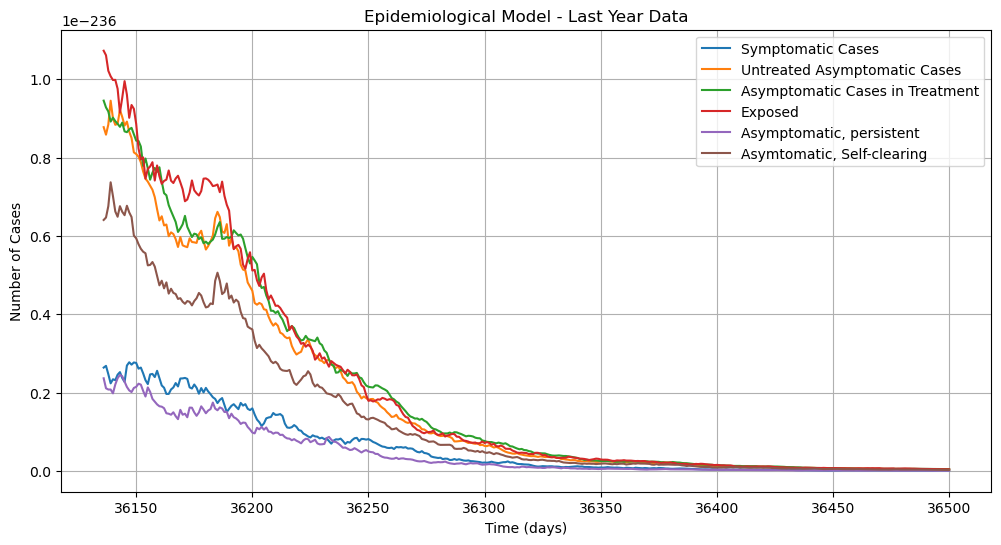

In [5]:


import matplotlib.pyplot as plt

# Extract the last year's data
last_year_data = solution[-365:]

# Separate data for different cases
symptomatic_cases = last_year_data[:, 2]
exposed_cases = last_year_data[:,1]
susceptible_cases = last_year_data[:,0]
untreated_asymptomatic_cases = last_year_data[:, 3] + last_year_data[:, 4]
persistent_cases=last_year_data[:,4]
selfclearing_cases=last_year_data[:,3]
asymptomatic_cases_in_treatment = last_year_data[:, 5]

# Time points for the last year
time_last_year = t_points[-365:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_last_year, symptomatic_cases, label='Symptomatic Cases')
plt.plot(time_last_year, untreated_asymptomatic_cases, label='Untreated Asymptomatic Cases')
plt.plot(time_last_year, asymptomatic_cases_in_treatment, label='Asymptomatic Cases in Treatment')
plt.plot(time_last_year, exposed_cases, label='Exposed')
#plt.plot(time_last_year, susceptible_cases, label='Susceptible')
plt.plot(time_last_year, persistent_cases, label='Asymptomatic, persistent')
plt.plot(time_last_year, selfclearing_cases, label='Asymtomatic, Self-clearing')
plt.xlabel('Time (days)')
plt.ylabel('Number of Cases')
plt.title('Epidemiological Model - Last Year Data')
plt.legend()
plt.grid(True)
plt.show()
